## SMS Spam Detection

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import spacy

In [16]:
# detecting the encoding technique of the dataset
import chardet
with open('./spam.csv', 'rb') as file:
    result = chardet.detect(file.read())

# reading the dataset using the detected encoding technique
df = pd.read_csv('./spam.csv', encoding=result['encoding'])
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Data Preparation

In [17]:
# removing the extra columns 
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
# changing the columns names
df.columns = ['Label', 'Message']
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
# counting the Number of null values
100*df.isna().mean()

# no missing values are present in the dataset

Label      0.0
Message    0.0
dtype: float64

Text(0.5, 1.0, 'Pie Chart of the Proportion of the Spam messages')

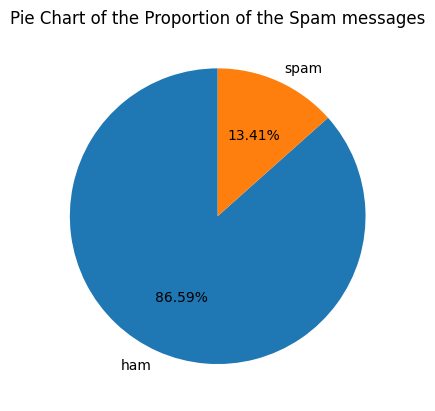

In [20]:
# proportion of the spam and correct message
category_count = df['Label'].value_counts()
plt.pie(category_count, startangle=90, labels=list(category_count.index), autopct='%.2f%%')
plt.title("Pie Chart of the Proportion of the Spam messages")

# around 13% of the messages are spam and the rest 87% are not spam. Therefore we can see there is a clear imbalance in the dataset

In [21]:
# loading spacy 'en-core-web-sm' model
nlp = spacy.load('en_core_web_sm')

In [22]:
# preprocessing
def preproc(text):
    doc = nlp(text) # creating nlp instance
    stp_removed = nlp(" ".join([token.text for token in doc if not token.is_stop])) # removig stop words
    lemm = " ".join([token.lemma_ for token in stp_removed]) # lemmatization
    text_without_punctuation = nlp(re.sub(r'[^\w\s]', '', lemm)) # removing puntuations
    clean_text = " ".join([token.text for token in text_without_punctuation if token.text != ' '])
    return clean_text

df['Message'] = df['Message'].apply(lambda x: preproc(x))

In [23]:
# encoding the label 
df['Label'] = df['Label'].replace({
    'ham': 0,
    'spam': 1
})

### Feature Extraction

In [24]:
# seperating the meassages and features
X = df['Message']
y = df['Label']

In [25]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, stratify=y)

In [26]:
vectorizer = TfidfVectorizer()
X_train_feat = pd.DataFrame(vectorizer.fit_transform(X_train).todense())
X_train_feat

,0,1,2,3,4,5,6,7,8,9,...,6866,6867,6868,6869,6870,6871,6872,6873,6874,6875
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X_train_feat.shape

(4179, 6876)

### Model Selection

In [28]:
# Logistic Regression Model Scores on Testing Dataset by Cross Validation
lr_score = np.mean(cross_val_score(LogisticRegression(), X_train_feat, y_train, cv=10))
lr_score

0.9449646024806949

In [29]:
# Gaussian Naive Bayes Model Scores on Testing Dataset by Cross Validation
gnb_score = np.mean(cross_val_score(GaussianNB(), X_train_feat, y_train, cv=10))
gnb_score

0.8674308400169816

### Main Model Building

In [53]:
# modification of the preproc function to apply over the entire dataset
def preprocess_func(X):
    return X.apply(lambda x: preproc(x))

# modification of the vectorizer to apply on the entire dataset
def convert_to_dense(X):
    return pd.DataFrame(X.todense())
    

# model pipeline
model = Pipeline([
    ('preproc', FunctionTransformer(preprocess_func)),
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
]) 

model.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 FunctionTransformer(func=<function preprocess_func at 0x000001A98A6FB4C0>)),
                ('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [55]:
# accuracy of the model
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9633883704235463

In [56]:
# classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1206
           1       0.99      0.74      0.84       187

    accuracy                           0.96      1393
   macro avg       0.97      0.87      0.91      1393
weighted avg       0.96      0.96      0.96      1393



Text(0.5, 1.0, 'Confusion Matrix of the classification Model')

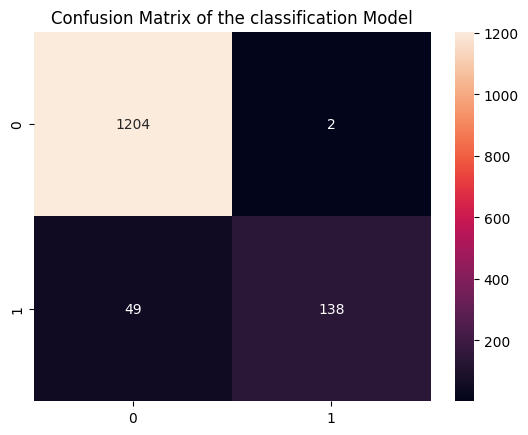

In [62]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Confusion Matrix of the classification Model")

In [64]:
# saving the Model 
with open('./model.pkl', 'wb') as f:
    pickle.dump(model, f)